https://noelee.tistory.com/236

In [1]:
import sys, os
p = os.path.abspath('..')
sys.path.insert(1, p)

pp = os.path.abspath('../../visualization')
sys.path.insert(1, pp)

In [2]:
import psycopg2
import pandas as pd
import numpy as np
from utils.statistics import *
import config.config as conf
import datetime
import re
from matplotlib import pyplot as plt
# 포뮬러 구성
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

In [3]:
output_dir = './fig/'
date_range = 'Daily'

In [4]:
conn = psycopg2.connect(host = conf.database_user['host'], dbname=conf.database_user['dbname'], user=conf.database_user['user'], password=conf.database_user['password'])
try:
    cur = conn.cursor()
    cur.execute("\
           select a.c_date               as c_date \
                , a.tag     as tag \
                , a.tag_count             as tag_count \
           from tag_for_did a \
; \
                " 
   )
    rows = cur.fetchall()
    

except psycopg2.DatabaseError as db_err:
    print(db_err)
finally : 
  cur.close()

In [5]:
df = pd.DataFrame(rows, columns = [
  'cdate' 
, 'tag' 
, 'tag_count'
])

In [6]:
df.sort_values(by=['cdate', 'tag'], ascending=True, inplace=True)

In [7]:
tot_df = df.groupby(['cdate'])['tag_count'].sum().reset_index(name='tot_cnt')

In [8]:
df_proportion = pd.merge(df, tot_df, on = 'cdate')
# .reset_index(name='count')

In [9]:
df_proportion['proportion'] = df_proportion['tag_count']/df_proportion['tot_cnt']

In [10]:
df_entropy = df_proportion.groupby(['cdate'])['proportion'].apply(lambda x : calculate_entropy(x)).to_frame(name = 'entropy').reset_index()
df_gini = df_proportion.groupby(['cdate'])['proportion'].apply(lambda x : calculate_gini(x)).to_frame(name = 'gini').reset_index()

In [11]:
df_coef = pd.merge(df_gini, df_entropy, on = 'cdate')

In [12]:
print(df_gini.shape)
print(df_entropy.shape)

(1099, 2)
(1099, 2)


In [13]:
df_coef.head()

,cdate,gini,entropy
0,2020-11-30,0.679385,6.679751
1,2020-12-01,0.683089,6.713969
2,2020-12-02,0.685342,6.718752
3,2020-12-03,0.689771,6.750750
4,2020-12-04,0.679014,6.733105


In [14]:
post_std_date = datetime.datetime(2022, 11, 30)
pre_std_date = datetime.datetime(2021, 12, 1)

In [15]:
df_coef['cdate'] = pd.to_datetime(df_coef['cdate'], format="%Y-%m-%d")

In [16]:
df_coef['post_std_diff'] = (df_coef['cdate'] - post_std_date).dt.days
df_coef['pre_std_diff'] = (df_coef['cdate'] - pre_std_date).dt.days

In [17]:
date_range = 7*15

In [18]:
df_coef.head()

,cdate,gini,entropy,post_std_diff,pre_std_diff
0,2020-11-30,0.679385,6.679751,-730,-366
1,2020-12-01,0.683089,6.713969,-729,-365
2,2020-12-02,0.685342,6.718752,-728,-364
3,2020-12-03,0.689771,6.750750,-727,-363
4,2020-12-04,0.679014,6.733105,-726,-362


In [19]:
df_coef_post = df_coef[((df_coef['post_std_diff']) >=-date_range) &((df_coef['post_std_diff']) <date_range) ]
df_coef_post = df_coef_post.rename(columns = {'post_std_diff':'std_diff'})

In [20]:
df_coef_pre = df_coef[((df_coef['pre_std_diff']) >=-date_range) &((df_coef['pre_std_diff']) <date_range) ]
df_coef_pre = df_coef_pre.rename(columns = {'pre_std_diff':'std_diff'})

In [21]:
df_coef_post.loc[:, 'treated'] = 1
df_coef_pre.loc[:, 'treated'] = 0

In [22]:
print(df_coef_post['cdate'].min())
print(df_coef_post['cdate'].max())
print(df_coef_pre['cdate'].min())
print(df_coef_pre['cdate'].max())

2022-08-17 00:00:00
2023-03-14 00:00:00
2021-08-18 00:00:00
2022-03-15 00:00:00


In [23]:
df_coef_post.loc[:, 'post'] = np.where(df_coef_post['std_diff'] >=0, 1, 0)
df_coef_pre.loc[:, 'post']  = np.where(df_coef_pre['std_diff'] >=0, 1, 0)

In [24]:
data = pd.concat([df_coef_post[['cdate', 'gini', 'entropy', 'std_diff', 'treated',
       'post']],   df_coef_pre[['cdate', 'gini', 'entropy', 'std_diff', 'treated',
       'post']]], axis= 0)

In [25]:
data['rel_week'] = np.floor(data['std_diff']/7)

In [26]:
print(data['rel_week'].min())
print(data['rel_week'].max())

-15.0
14.0


In [27]:
def calc_did(data, measure):
    data['rel_week'] = data['rel_week'].astype('category')
    data['std_diff'] = data['std_diff'].astype('category')
    # 회귀식: 주차별 상호작용 포함
    model = smf.ols(f"{measure} ~ C(rel_week) * treated", data=data)
    did_result = model.fit(cov_type='HAC', cov_kwds={'maxlags': 7}) 

    return did_result

In [28]:
def pp_did_result(did_result) :
    # 결과 정리
    periods = np.arange(list(data['rel_week'].unique())[1], list(data['rel_week'].unique())[-1]+1, 1)
    coefs = did_result.params
    std_errors = did_result.bse 
    conf = did_result.conf_int()
    coefs_filtered      = coefs.loc[[f'C(rel_week)[T.{i}]:treated' for i in periods]].values
    std_errors_filtered = std_errors.loc[[f'C(rel_week)[T.{i}]:treated' for i in periods]].values

    # 신뢰구간 계산
    ll_95 = coefs_filtered - 1.965 * std_errors_filtered
    ul_95 = coefs_filtered + 1.965 * std_errors_filtered

    # 데이터프레임 생성 (계수와 신뢰구간)
    df_coefs = pd.DataFrame({
        'period'    : periods,
        'Estimate'  : coefs_filtered,
        'll_95'     : ll_95,
        'ul_95'     : ul_95
    })
    return df_coefs




In [29]:
g_did_result = calc_did(data, 'gini')
e_did_result = calc_did(data, 'entropy')

g_event_effects = pp_did_result(g_did_result)
e_event_effects = pp_did_result(e_did_result)


In [33]:
event_effects_dict = dict()
event_effects_dict['Gini coefficient'] = g_event_effects
event_effects_dict['Entropy'] = e_event_effects

In [36]:
alpha_dict = {0 : 'A. ', 1 : 'B. '}

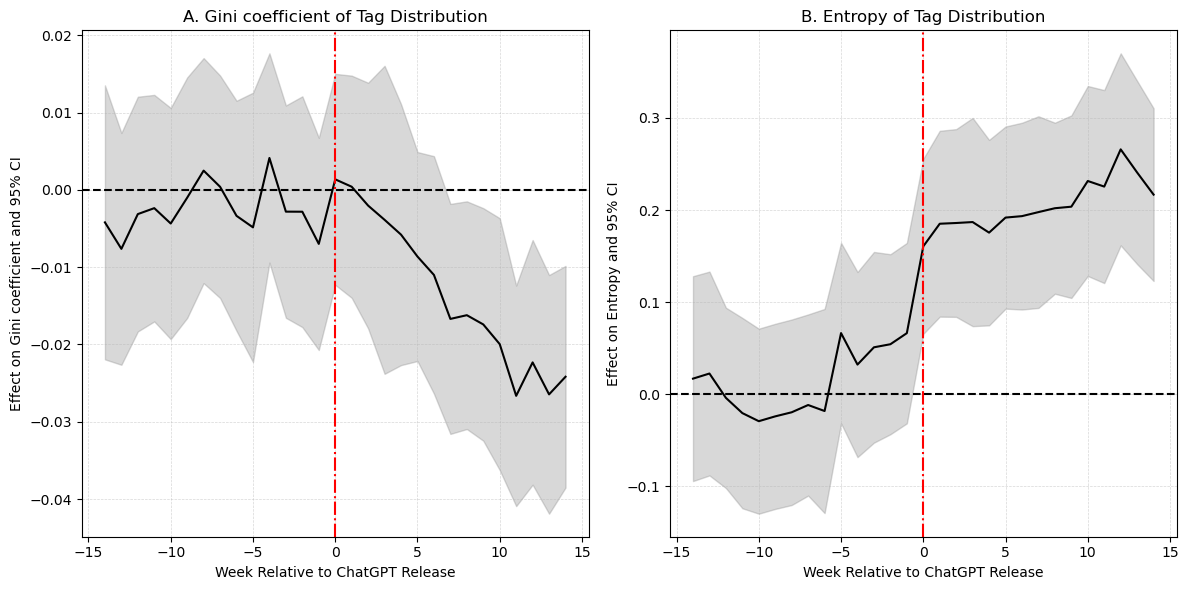

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 신뢰구간 영역
for idx, measure in enumerate(event_effects_dict):
    ax[idx].fill_between(event_effects_dict[measure]['period'], event_effects_dict[measure]['ll_95'], event_effects_dict[measure]['ul_95'],
                    color='gray', alpha=0.3)
    ax[idx].plot(event_effects_dict[measure]['period'], event_effects_dict[measure]['Estimate'], color='black', label='DID Estimate')

    # 기준선
    ax[idx].axhline(0, linestyle='--', color='black')
    ax[idx].axvline(0, linestyle='dashdot', color='red', label='ChatGPT Release')

    # 축 라벨과 제목
    ax[idx].set_xlabel("Week Relative to ChatGPT Release")
    ax[idx].set_ylabel(f"Effect on {measure} and 95% CI")
    ax[idx].set_title(f"{alpha_dict[idx]}{measure} of Tag Distribution")
    ax[idx].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

plt.savefig(f"{output_dir}Result_Fig5.png", dpi=300, bbox_inches='tight')
# ax.legend()
plt.tight_layout()
plt.show()
